In [1]:
import pandas as pd
from transformers import pipeline
import re

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

C:\Users\Raakh\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
No module named 'distutils'

In [3]:
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raakh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raakh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raakh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv("subs2\\fatpeoplehate_submissions.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mod_reports             606 non-null    object 
 1   selftext                138 non-null    object 
 2   selftext_html           144 non-null    object 
 3   id                      606 non-null    object 
 4   title                   606 non-null    object 
 5   banned_by               0 non-null      float64
 6   thumbnail               606 non-null    object 
 7   secure_media_embed      606 non-null    object 
 8   secure_media            41 non-null     object 
 9   edited                  606 non-null    object 
 10  permalink               606 non-null    object 
 11  is_self                 606 non-null    bool   
 12  media_embed             606 non-null    object 
 13  author                  606 non-null    object 
 14  gilded                  606 non-null    in

In [6]:
df.head(5)

,mod_reports,selftext,selftext_html,id,title,banned_by,thumbnail,secure_media_embed,secure_media,edited,...,user_reports,url,over_18,subreddit,media,score,report_reasons,created_utc,retrieved_on,domain
0,[],"I have minimal experience, and I wouldn't be v...","&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",1el2un,Anyone can be a moderator? I wanna be one.,NaN,self,{},NaN,False,...,[],http://www.reddit.com/r/fatpeoplehate/comments...,False,fatpeoplehate,NaN,11,NaN,1368898307,1412336060,self.fatpeoplehate
1,[],Overweight people are not oppressed. Obese peo...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",1eq75b,When people use their weight as an excuse to c...,NaN,self,{},NaN,False,...,[],http://www.reddit.com/r/fatpeoplehate/comments...,False,fatpeoplehate,NaN,63,NaN,1369092201,1412328642,self.fatpeoplehate
2,[],NaN,NaN,1eq3ky,This fucking shit,NaN,default,{},NaN,False,...,[],http://i.imgur.com/rxHAZRR.jpg,False,fatpeoplehate,NaN,99,NaN,1369089497,1412328774,i.imgur.com
3,[],NaN,NaN,1epz78,Why do you hate fat people?,NaN,self,{},NaN,False,...,[],http://www.reddit.com/r/fatpeoplehate/comments...,False,fatpeoplehate,NaN,13,NaN,1369086317,1412328943,self.fatpeoplehate
4,[],NaN,NaN,1esfe2,Fuck this. (TED talk on why it's okay to be fat),NaN,default,{},NaN,False,...,[],http://www.youtube.com/watch?v=73SXX0w4eY8,False,fatpeoplehate,"{'type': 'youtube.com', 'oembed': {'author_nam...",44,NaN,1369170518,1412325488,youtube.com


In [17]:
df.describe

<bound method NDFrame.describe of                                               selftext      id  \
0    I have minimal experience, and I wouldn't be v...  1el2un   
1    Overweight people are not oppressed. Obese peo...  1eq75b   
7     It's not a fucking "privilege" to be thin. Th...  1eyfub   
9    Why are they trying to make these hambeasts lo...  1f6ft0   
10   This is Chapter Two following the short bit I ...  1ff2ak   
..                                                 ...     ...   
590  Welcome back everyone. I extend my greatest ap...  1txyt8   
592                                                ///  1u1mj2   
597  **Fat privilege is**:\n\n* Not having your bos...  1tzs6v   
598                                   /r/fatpeoplehate  1tzlsf   
605  I was chuckling to myself thinking of a privat...  1u23rc   

                                                 title  \
0           Anyone can be a moderator? I wanna be one.   
1    When people use their weight as an excuse to c...   

In [7]:
df.shape

(606, 35)

In [8]:
df['selftext'].isnull().sum()

468

In [9]:
columns_to_drop = ["banned_by", "thumbnail", "secure_media_embed", "secure_media",
                   "edited", "permalink", "is_self", "media_embed", "author",
                   "gilded", "link_flair_css_class", "author_flair_css_class",
                   "stickied", "author_flair_text", "link_flair_text",
                   "distinguished", "num_comments", "user_reports",
                   "url", "over_18", "subreddit", "media", "score",
                   "report_reasons", "created_utc", "retrieved_on", "domain", "subreddit_id", "downs", "ups", "mod_reports","selftext_html"]


columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

df = df.drop(columns=columns_to_drop_existing)

In [10]:
df.head(5)

,selftext,id,title
0,"I have minimal experience, and I wouldn't be v...",1el2un,Anyone can be a moderator? I wanna be one.
1,Overweight people are not oppressed. Obese peo...,1eq75b,When people use their weight as an excuse to c...
2,NaN,1eq3ky,This fucking shit
3,NaN,1epz78,Why do you hate fat people?
4,NaN,1esfe2,Fuck this. (TED talk on why it's okay to be fat)


In [11]:
# Drop rows with NaN values in the 'selftext' column
df = df.dropna(subset=['selftext'])

In [12]:
df.head(5)

,selftext,id,title
0,"I have minimal experience, and I wouldn't be v...",1el2un,Anyone can be a moderator? I wanna be one.
1,Overweight people are not oppressed. Obese peo...,1eq75b,When people use their weight as an excuse to c...
7,"It's not a fucking ""privilege"" to be thin. Th...",1eyfub,"I hate when fat people complain about Thin ""Pr..."
9,Why are they trying to make these hambeasts lo...,1f6ft0,Sexy bras for sexy curves
10,This is Chapter Two following the short bit I ...,1ff2ak,FatTatz Makes an Unprofitable Business Venture


In [13]:
# Handle missing values in 'selftext'
df['selftext'].fillna('', inplace=True)

# Define functions for text preprocessing
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Tokenization
def tokenize_text(text):
    return word_tokenize(text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply preprocessing to the 'selftext' column
for index, row in df.iterrows():
    text = row['selftext']
    text = preprocess_text(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    processed_text = ' '.join(tokens)
    df.at[index, 'processed_selftext'] = processed_text

# Now df['processed_selftext'] contains the preprocessed selftext
print(df[['processed_selftext']])

C:\Users\Raakh\AppData\Local\Temp\ipykernel_10044\478690561.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['selftext'].fillna('', inplace=True)


                                    processed_selftext
0    minimal experience wouldnt active think id mak...
1    overweight people oppressed obese people never...
7    fucking privilege thin there special right adv...
9    trying make hambeasts look sexy girl chunky fu...
10   chapter two following short bit posted earlier...
..                                                 ...
590  welcome back everyone extend greatest apprecia...
592                                                   
597  fat privilege bos grab tensed arm comment smal...
598                                     rfatpeoplehate
605  chuckling thinking private investigator follow...

[138 rows x 1 columns]


DATA VISUALIZATIONS

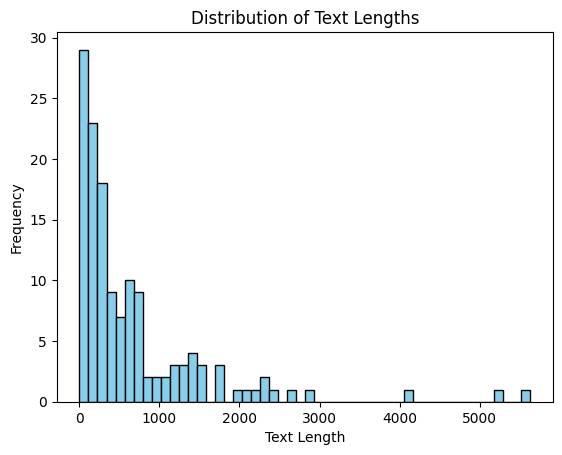

In [14]:
# import matplotlib.pyplot as plt

# # Calculate the length of each processed selftext
# text_lengths = df['processed_selftext'].apply(lambda x: len(x))

# # Create a histogram to visualize the distribution of text lengths
# plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
# plt.xlabel('Text Length')
# plt.ylabel('Frequency')
# plt.title('Distribution of Text Lengths')
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from wordcloud import WordCloud

# # Iterate through the 'selftext' column, preprocess each selftext, and compute toxicity score
# toxicity_scores = []
# for selftext in df['selftext']:
#     # Clean the selftext
#     cleaned_selftext = clean_selftext(selftext)

#     # Get toxicity score from Perspective API
#     toxicity_score = get_toxicity_score(cleaned_selftext)

#     toxicity_scores.append(toxicity_score)

# # Add the toxicity scores to the DataFrame
# df['toxicity_score'] = toxicity_scores

# # Word Cloud
# wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(df['processed_selftext']))
# plt.figure(figsize=(10, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud of Processed Selftext')
# plt.show()

# # Bar Plot
# plt.figure(figsize=(8, 6))
# sns.countplot(data=df, x='toxicity_score', palette='viridis')
# plt.title('Distribution of Toxicity Scores')
# plt.xlabel('Toxicity Score')
# plt.ylabel('Count')
# plt.show()

# # Box Plot
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df, x='toxicity_score', color='skyblue')
# plt.title('Box Plot of Toxicity Scores')
# plt.xlabel('Toxicity Score')
# plt.show()

# # Violin Plot
# plt.figure(figsize=(8, 6))
# sns.violinplot(data=df, x='toxicity_score', color='salmon')
# plt.title('Violin Plot of Toxicity Scores')
# plt.xlabel('Toxicity Score')
# plt.show()


In [15]:
# Load the pre-trained model for text classification
classifier = pipeline('text-classification', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Assuming you have already loaded your DataFrame df with preprocessed 'processed_selftext' column
# Compute toxicity scores
def compute_toxicity_score(df):
    # Initialize toxicity scores list
    toxicity_scores = []

    # Iterate through the 'processed_selftext' column and compute toxicity score
    for processed_selftext in df['processed_selftext']:
        # Classify sentiment for long texts
        segments = [processed_selftext[i:i + 512] for i in range(0, len(processed_selftext), 512)]

        # Initialize an empty list to store sentiment scores
        scores = []

        # Iterate through segments and classify sentiment
        for segment in segments:
            try:
                result = classifier(segment)[0]
                score = result['score']
                scores.append(score)
            except Exception as e:
                print(f"Error occurred during sentiment analysis: {str(e)}")

        # Append the average sentiment score if scores list is not empty, else append 0
        toxicity_scores.append(sum(scores) / len(scores) if len(scores) > 0 else 0)

    # Add the toxicity scores to the DataFrame
    df['toxicity_score'] = toxicity_scores

    # Print the DataFrame with toxicity scores
    print(df[['processed_selftext', 'toxicity_score']])

# Assuming df is your DataFrame with a copylumn named 'processed_selftext' containing preprocessed text
compute_toxicity_score(df)


                                    processed_selftext  toxicity_score
0    minimal experience wouldnt active think id mak...        0.309759
1    overweight people oppressed obese people never...        0.892937
7    fucking privilege thin there special right adv...        0.293657
9    trying make hambeasts look sexy girl chunky fu...        0.468971
10   chapter two following short bit posted earlier...        0.630091
..                                                 ...             ...
590  welcome back everyone extend greatest apprecia...        0.671057
592                                                           0.000000
597  fat privilege bos grab tensed arm comment smal...        0.484525
598                                     rfatpeoplehate        0.306443
605  chuckling thinking private investigator follow...        0.557507

[138 rows x 2 columns]


In [16]:
df.iloc[45:90]

,selftext,id,title,processed_selftext,toxicity_score
191,"I'm going to share one of the worst, if not th...",1m61a7,Thin privilege is being able to wipe your own ...,im going share one worst worst thing obese dea...,0.603320
192,So I needed somewhere to quickly vent on reddi...,1m5yvw,My thoroughly unpleasant encounter with a pork...,needed somewhere quickly vent reddit entitled ...,0.612859
201,"Good for you for getting to the gym, but pleas...",1mgjca,Fatties in the gym,good getting gym please wipe as shower properl...,0.369494
202,"It's simple math, physics and chemistry and th...",1mfqon,Fat people ignore the Laws of Thermodynamics a...,simple math physic chemistry application law t...,0.583799
204,"It's good. I am a 19 year old male, 5'11"", 300...",1mex3y,"As a fat person, my view on fatpeoplehate",good year old male lb reason im fat lazy never...,0.324633
212,"Yes, I hate fat people and fat women in partic...",1msd6m,I'm here to share the love.,yes hate fat people fat woman particular theyr...,0.645051
216,Married almost 25 years. He is very successful...,1mtjml,My hubs is a Planet,married almost year successful fat fit yo foot...,0.382560
221,What's going on you little piggies? I know it'...,1mzaxs,"""I can't believe I'm actually asking this..."" ...",whats going little piggy know surprise shit iv...,0.661820
224,Hello. I am writing an article and I need some...,1n23wk,Dear /r/FatPeopleHate - I need your help,hello writing article need opinion ive reading...,0.612795
228,So my wife and I had our daughter in soccer. ...,1mzw2a,Tubby goes bananas!,wife daughter soccer soccer coach hefty woman ...,0.475911


In [29]:
import pandas_profiling

# Use Pandas Profiling
profile = pandas_profiling.ProfileReport(df)
profile.to_file("pandas_profiling_report.html")

PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.6/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.6/u/import-error

In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Load the pre-trained model for text classification
classifier = pipeline('text-classification', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Assuming you have already loaded your DataFrame df with preprocessed 'processed_selftext' column
# Compute toxicity scores
def compute_toxicity_score(df):
    # Initialize toxicity scores list
    toxicity_scores = []

    # Iterate through the 'processed_selftext' column and compute toxicity score
    for processed_selftext in df['processed_selftext']:
        # Classify sentiment for long texts
        segments = [processed_selftext[i:i + 512] for i in range(0, len(processed_selftext), 512)]

        # Initialize an empty list to store sentiment scores
        scores = []

        # Iterate through segments and classify sentiment
        for segment in segments:
            try:
                result = classifier(segment)[0]
                score = result['score']
                scores.append(score)
            except Exception as e:
                print(f"Error occurred during sentiment analysis: {str(e)}")

        # Append the average sentiment score if scores list is not empty, else append 0
        toxicity_scores.append(sum(scores) / len(scores) if len(scores) > 0 else 0)

    # Add the toxicity scores to the DataFrame
    df['toxicity_score'] = toxicity_scores

    # Print the DataFrame with toxicity scores
    print(df[['processed_selftext', 'toxicity_score']])

# Hyperparameter tuning using Grid Search
def hyperparameter_tuning(df):
    # Define pipeline with TfidfVectorizer and SVM classifier
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', SVC())
    ])

    # Define parameter grid for Grid Search
    param_grid = {
        'tfidf__max_df': (0.25, 0.5, 0.75),
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [1, 10, 100],
        'clf__kernel': ['linear', 'rbf']
    }

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(df['processed_selftext'], df['toxicity_score'])

    # Print the best parameters and score
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Assuming df is your DataFrame with a column named 'processed_selftext' containing preprocessed text
# compute_toxicity_score(df)

# Perform hyperparameter tuning
hyperparameter_tuning(df)
